In [21]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import networkx as nx
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.python.ops import gen_array_ops
from PIL import Image

# the file remains as the same, but get different data (to be compared and calculates bandwidth mean)

In [22]:
tf.executing_eagerly()

True

In [23]:
NUMBER_NODES = 7

def load_data():
    train_df = pd.read_csv(os.path.join('..', 'DNN', 'datasets', f'dataset_{NUMBER_NODES}_train.csv'))
    val_df = pd.read_csv(os.path.join('..', 'DNN', 'datasets', f'dataset_{NUMBER_NODES}_val.csv'))
    test_df = pd.read_csv(os.path.join('..', 'DNN', 'datasets', f'dataset_{NUMBER_NODES}_test.csv'))

    featuresNumber = (NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2 
    def get_tuple_tensor_dataset(row):
        X = row[0 : featuresNumber].astype('float32')
        Y = row[featuresNumber + 1: ].astype('float32') # Pula a banda otima na posicao 0
        return X, Y

    train_dataset = list(map(get_tuple_tensor_dataset, train_df.to_numpy()))
    val_dataset = list(map(get_tuple_tensor_dataset, val_df.to_numpy()))
    test_dataset = list(map(get_tuple_tensor_dataset, test_df.to_numpy()))

    X = []
    Y = []
    for x, y in train_dataset:
        X.append(x)
        Y.append(y)
    x_train = np.array(X)
    y_train = np.array(Y)

    X = []
    Y = []
    for x, y in test_dataset:
        X.append(x)
        Y.append(y)
    x_test = np.array(X)
    y_test = np.array(Y)

    X = []
    Y = []
    for x, y in val_dataset:
        X.append(x)
        Y.append(y)
    x_val = np.array(X)
    y_val = np.array(Y)

    x_train = np.concatenate((x_train, x_val))
    y_train = np.concatenate((y_train, y_val))


    return x_train, y_train, x_test, y_test

In [24]:
X, y, x_t, y_t = load_data()

In [25]:
print(X.shape)
print(y.shape)

(981, 21)
(981, 7)


[[0 0 1 0 1 1 1]
 [0 0 0 1 1 0 1]
 [1 0 0 0 1 1 0]
 [0 1 0 0 0 1 1]
 [1 1 1 0 0 0 1]
 [1 0 1 1 0 0 1]
 [1 1 0 1 1 1 0]]


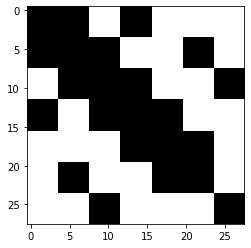

In [26]:
def getGraph(upperTriangleAdjMatrix):
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    k = 0
    for i in range(NUMBER_NODES):
        for j in range(NUMBER_NODES):
            if i == j:
                continue
            elif i < j:
                dense_adj[i][j] = upperTriangleAdjMatrix[k]
                k += 1
            else:
                dense_adj[i][j] = dense_adj[j][i]
    return dense_adj

def processDataToAdjImage(graphInput):
    adj = getGraph(graphInput)
    w, h = NUMBER_NODES, NUMBER_NODES
    data = np.zeros((h, w, 3), dtype=np.uint8)
    for i in range(len(adj)):
        for j in range(len(adj)):
            if adj[i, j] == 1:
                data[i, j] = np.array([255.0, 255.0, 255.0])
    img = Image.fromarray(data, 'RGB')
    resized = img.resize((NUMBER_NODES * 4, NUMBER_NODES * 4), Image.NEAREST)
    image_input_np = np.array(resized)
    return image_input_np
# def processDataToImage(graphInput):
#     graph_adj = getGraph(graphInput)
#     plt.imshow(graph_adj, cmap="gray")
#     plt.xticks([])
#     plt.yticks([])
#     plt.savefig(f'./Graph_adj_input_mse.png')
#     plt.clf()
#     image_input = tf.keras.preprocessing.image.load_img(f'./Graph_adj_input_mse.png')
#     image_input_arr = tf.keras.preprocessing.image.img_to_array(image_input)
#     image_input_np = np.array(image_input_arr)
#     # image_input_np = image_input_np / 255.0

#     image_input_np = tf.image.resize(image_input_np, [32, 32])
#     return image_input_np
print(getGraph(X[0]).astype(np.int32))
img = processDataToAdjImage(X[0])
plt.imshow(img)

In [27]:
def getData_2(features, labels):
    train_images = []
    train_nodelist = []
    for graphInput, target in zip(features, labels):
        graphNodeList = target
        x_image = processDataToAdjImage(graphInput)
        train_images.append(x_image)
        train_nodelist.append(graphNodeList)
    # mlb = MultiLabelBinarizer()
    # labels = mlb.fit_transform(train_nodelist)
    return np.array(train_images), np.array(train_nodelist)

In [28]:
X_train, y_train = getData_2(X, y)
x_test, y_test = getData_2(x_t, y_t)

print(X_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(981, 28, 28, 3)
(981, 7)
(63, 28, 28, 3)
(63, 7)


In [29]:
it = iter(X_train)
it2 = iter(X)
entry = next(it)
entry2 = next(it2)
getGraph(entry2)

array([[0., 0., 1., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1., 0., 1.],
       [1., 0., 0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 0., 1., 1.],
       [1., 1., 1., 0., 0., 0., 1.],
       [1., 0., 1., 1., 0., 0., 1.],
       [1., 1., 0., 1., 1., 1., 0.]])

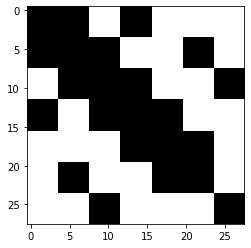

<Figure size 432x288 with 0 Axes>

In [30]:
plt.imshow(entry)
plt.show()
plt.clf()

In [31]:
# This cell is to show an example of the custom loss
def body_example(i, acc, out):
  used_labels, indexes, counts = tf.unique_with_counts(tf.squeeze(out[i]))
  counts = tf.cast(counts, tf.float32)
  variance = tf.math.reduce_variance(counts)
  return (i + 1, tf.add(acc, variance), out)

def loss_repeated_labels_example(roundedOutput):
  acc = tf.constant(0, dtype=tf.float32)
  out = roundedOutput
  batch_size = tf.shape(roundedOutput)[0]

  i = tf.constant(0)
  c = lambda i, acc, out: tf.less(i, batch_size)
  b = body_example
  r = tf.while_loop(c, b, loop_vars=[i, acc, out])
  return r

output = tf.constant([[1, 2, 1], [3, 4, 3]])
output[0]

i, loss, out = loss_repeated_labels_example(output)
print(i)
print(loss)
print(out)

used_labels, indexes, counts1 = tf.unique_with_counts(output[0])
used_labels, indexes, counts2 = tf.unique_with_counts(output[1])
counts1 = tf.cast(counts1, tf.float32)
counts2 = tf.cast(counts2, tf.float32)
variance1 = tf.math.reduce_variance(counts1)
variance2 = tf.math.reduce_variance(counts2)
print(variance1)
print(variance2)
print(tf.add(variance1, variance2))

tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(0.5, shape=(), dtype=float32)
tf.Tensor(
[[1 2 1]
 [3 4 3]], shape=(2, 3), dtype=int32)
tf.Tensor(0.25, shape=(), dtype=float32)
tf.Tensor(0.25, shape=(), dtype=float32)
tf.Tensor(0.5, shape=(), dtype=float32)


In [32]:
import tensorflow.keras.backend as K

mseLoss = tf.keras.losses.MeanSquaredError()

def loss_repeated_labels(roundedOutput):
  def body(i, acc, out):
    used_labels, indexes, counts = tf.unique_with_counts(tf.squeeze(out[i]))
    counts = tf.cast(counts, tf.float32)
    variance = tf.math.reduce_variance(counts)
    return (i + 1, tf.add(acc, variance), out)
  
  acc = tf.constant(0, dtype=tf.float32)
  out = roundedOutput
  batch_size = tf.shape(out)[0]

  i = tf.constant(0)
  condition = lambda i, acc, out: tf.less(i, batch_size)
  b = body
  result = tf.while_loop(condition, b, loop_vars=[i, acc, out])
  return result

def custom_loss(true, pred):
  mse = mseLoss(true, pred)
  roundedOutput = tf.round(pred)
  i, loss_repeated, roundedOutput = loss_repeated_labels(roundedOutput)
  return mse + loss_repeated

In [33]:
data_augmentation = tf.keras.Sequential(
  [
    # layers.RandomFlip("horizontal", input_shape=(32, 32, 3)),
    layers.RandomRotation(0.2),
  ]
)

model = tf.keras.models.Sequential([
  data_augmentation, # with aug mean band = 4.571428571428571, without = 4.603174603174603
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(NUMBER_NODES)
])

In [34]:
batch_size = 64

model.compile(optimizer='adam',
              loss=custom_loss,
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(x_test, y_test),
    epochs=128,
    batch_size=batch_size,
)

Epoch 1/128
16/16 [==============================] - 3s 76ms/step - loss: 47.4589 - accuracy: 0.2304 - val_loss: 79.9860 - val_accuracy: 0.4127
Epoch 2/128
16/16 [==============================] - 1s 58ms/step - loss: 78.7977 - accuracy: 0.2926 - val_loss: 38.7059 - val_accuracy: 0.3016
Epoch 3/128
16/16 [==============================] - 1s 59ms/step - loss: 51.0791 - accuracy: 0.3221 - val_loss: 42.5790 - val_accuracy: 0.3333
Epoch 4/128
16/16 [==============================] - 1s 58ms/step - loss: 66.0122 - accuracy: 0.3252 - val_loss: 64.3866 - val_accuracy: 0.4127
Epoch 5/128
16/16 [==============================] - 1s 61ms/step - loss: 53.7101 - accuracy: 0.3649 - val_loss: 59.0873 - val_accuracy: 0.3651
Epoch 6/128
16/16 [==============================] - 1s 59ms/step - loss: 60.1151 - accuracy: 0.3384 - val_loss: 37.6542 - val_accuracy: 0.4603
Epoch 7/128
16/16 [==============================] - 1s 59ms/step - loss: 54.2058 - accuracy: 0.3333 - val_loss: 58.3530 - val_accuracy:

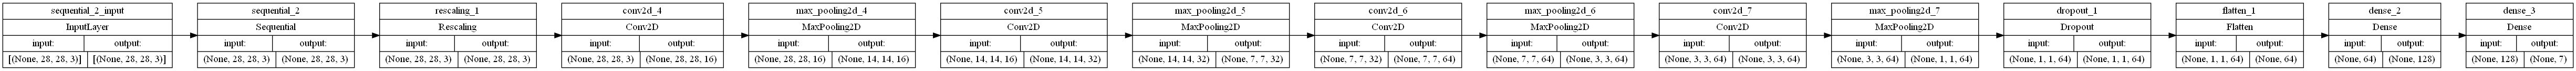

In [35]:
tf.keras.utils.plot_model(
    model,
    # to_file='model.png',
    rankdir='LR',
    show_shapes=True,
)

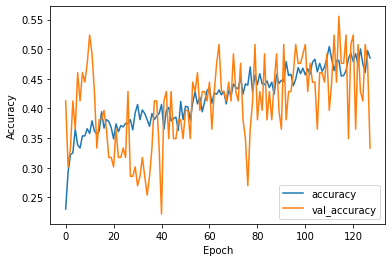

In [36]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

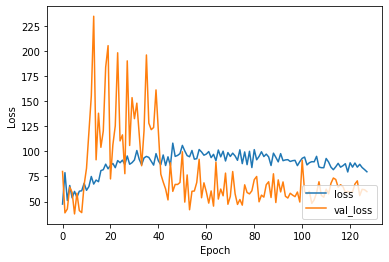

In [37]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [38]:
def count_repeats(output):
    counts = np.unique(np.round(output))
    repeated = NUMBER_NODES - counts.shape[0]
    return repeated

def get_valid_pred(pred):
    valid = np.ones(NUMBER_NODES)
    labels = np.arange(0, NUMBER_NODES)
    for i in labels:
        min_value = np.amin(pred)
        min_idx = np.where(pred == min_value)
        pred[min_idx] = 100
        valid[min_idx] = i
    return valid
    
def get_bandwidth(Graph, nodelist):
    Graph = nx.Graph(Graph)
    if not Graph.edges:
        return 0
    if nodelist.all() != None:
        L = nx.laplacian_matrix(Graph, nodelist=nodelist)
    else:
        L = nx.laplacian_matrix(Graph)
    x, y = np.nonzero(L)
    return (x-y).max()

def get_array_from_image(graphnp):
    img = Image.fromarray(graphnp, 'RGB')
    img = img.convert('L')
    resized = img.resize((NUMBER_NODES, NUMBER_NODES), Image.NEAREST)
    image_input_np = np.array(resized)
    return image_input_np / 255

In [39]:
import time

pred = model.predict(x_test)

sumTest_original = []
sumTest_pred = []
sumTest_true = []

count = 0
cases_with_repetition = 0

start = time.time()
for i in range(len(pred)):
    output = pred[i]
    quantity_repeated = count_repeats(np.round(output))
    print('Pred: ', output)
    print('True: ', y_test[i])
    if quantity_repeated != 0:
        cases_with_repetition += 1
    output = get_valid_pred(output)
    print('Pred valid: ', output)
    count += quantity_repeated

    graph = get_array_from_image(x_test[i])

    original_band = get_bandwidth(graph, np.array(None))
    sumTest_original.append(original_band)

    pred_band = get_bandwidth(graph, output)
    sumTest_pred.append(pred_band)

    true_band = get_bandwidth(graph, y_test[i])
    sumTest_true.append(true_band)

    # print("Bandwidth")
    # print(original_band)
    # print(pred_band)
    # print(true_band)
end = time.time()

Pred:  [1.0388368 4.510283  3.0473092 0.9088266 2.2509172 3.321991  2.9594452]
True:  [1. 5. 6. 0. 3. 2. 4.]
Pred valid:  [1. 6. 4. 0. 2. 5. 3.]
Pred:  [1.9443961 1.3362994 3.113404  4.7344403 4.163074  1.383628  2.5687473]
True:  [3. 0. 6. 4. 5. 2. 1.]
Pred valid:  [2. 0. 4. 6. 5. 1. 3.]
Pred:  [1.702778  3.850728  3.538294  1.4499457 2.1678212 2.9277127 2.6060503]
True:  [1. 5. 6. 0. 2. 4. 3.]
Pred valid:  [1. 6. 5. 0. 2. 4. 3.]
Pred:  [1.9821655 4.2323484 3.0558481 1.1428605 2.4238276 3.2926724 2.7396843]
True:  [2. 0. 4. 6. 5. 1. 3.]
Pred valid:  [1. 6. 4. 0. 2. 5. 3.]
Pred:  [1.4318388 3.4459283 3.1521351 1.4473729 2.4417145 2.7413335 2.5676336]
True:  [1. 2. 6. 4. 0. 5. 3.]
Pred valid:  [0. 6. 5. 1. 2. 4. 3.]
Pred:  [2.5705435 1.5819359 2.6270173 4.4774833 2.9565327 1.4735733 2.38285  ]
True:  [4. 0. 2. 6. 5. 3. 1.]
Pred valid:  [3. 1. 4. 6. 5. 0. 2.]
Pred:  [1.9900597 3.1795824 2.7841861 1.8610265 2.813246  2.6886878 2.6127508]
True:  [2. 3. 1. 4. 5. 6. 0.]
Pred valid:  [1. 6. 4

In [40]:
print('Quantidade de rótulos repetidos, exemplo [1, 1, 1, 1, 1, 1, 1] conta como 6 - ', count)
print('Quantidade de saídas com repetição, exemplo [1, 1, 1, 1, 1, 1, 1] conta como 1 - ', cases_with_repetition)
test_length = pred.shape[0]
print('Test length - ', test_length)
print('Time- ', (end - start) / test_length)

print("Bandwidth mean±std")
print(f'{np.mean(sumTest_original)}±{np.std(sumTest_original)}')
print("Pred bandwidth mean±std")
print(f'{np.mean(sumTest_pred)}±{np.std(sumTest_pred)}')
print("True bandwidth mean±std")
print(f'{np.mean(sumTest_true)}±{np.std(sumTest_true)}')

Quantidade de rótulos repetidos, exemplo [1, 1, 1, 1, 1, 1, 1] conta como 6 -  237
Quantidade de saídas com repetição, exemplo [1, 1, 1, 1, 1, 1, 1] conta como 1 -  63
Test length -  63
Time-  0.005047688408503457
Bandwidth mean±std
5.904761904761905±0.2935435239509036
Pred bandwidth mean±std
4.682539682539683±0.8323879747382154
True bandwidth mean±std
3.1904761904761907±0.7095078297976829
